# Lab 3 - Logistic Regression

In this lab we implement and use logistic regressione for binary claffication problems.

We start including some libraries and functions already seen in the previous labs (or slight variations of them). Have a look and verify you understand their purpose.

<b>READ all the text parts very carefully, as you will find instructions on how to proceed.</b>

In [53]:
# import libraries
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata
import math
from random import randint

plt.rcParams["figure.figsize"] = (15,8)

In [54]:
def mixGauss(means, sigmas, n):
    """
    means : 2D array (num_classes, d)
        Each row of the array gives the mean of the Gaussian in multiple dimensions for one class.
        For binary classification problems, the number of rows should be 2!
    sigmas : 1D array (num_classes)
        The standard deviation for the Gaussian distribution of each class (isotropic Gaussian!)
    
    Example:
    
    >>> means = [[3, 0], [0, 0]]
    >>> sigmas = [0.5, 1]
    >>> X, Y = mixGauss(means, sigmas, n=100)
    >>> fig, ax = plt.subplots()
    >>> ax.scatter(X[Y == 1,0], X[Y == 1,1], marker='o', color='r')
    >>> ax.scatter(X[Y == -1,0], X[Y == -1,1], marker='o', color='b')
    """
    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(
            mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2, size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

In [55]:
def flipLabels(Y, perc):
    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

In [56]:
def separatingFLR(Xtr, Ytr, Ypred, w):
    fig, ax = plt.subplots()
    xi = np.linspace(Xtr[:, 0].min(), Xtr[:, 0].max(), 200)
    yi = np.linspace(Xtr[:, 1].min(), Xtr[:, 1].max(), 200)
    X, Y = np.meshgrid(xi,yi)
    
    zi = griddata(Xtr, Ypred, (X,Y), method='linear')
    ax.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    ax.scatter(Xtr[:,0], Xtr[:,1], c=Ytr, marker='o', s=100, zorder=10, alpha=0.8) # type: ignore
    ax.set_xlim(Xtr[:,0].min(), Xtr[:,0].max())
    ax.set_ylim(Xtr[:,1].min(), Xtr[:,1].max())
    plt.show()

## Linear logistic regression with gradient descent

We define two functions:
 - the `optimal_gd_learning_rate(Xtr, reg_par)` function calculates the optimal learning rate for GD on a given dataset. You will need to use the SVD of the covariance matrix.
 - the `train_logreg_gd(Xtr, Ytr, reg_par, maxiter)` function estimates the classifier weights on the training set.

<br>

The parameters of the `optimal_gd_learning_rate` function are:
- <b>Xtr</b> is the nxD matrix of training set inputs
- <b>reg_par</b> is the value of the lammbda

and it should output the learning rate $\gamma$ (a scalar).
You should use the `np.linalg.eigvalsh` function to calculate the eigenvalues of the covariance matrix.

<br>

The parameters of the `train_logreg_gd` function are:
- <b>Xtr</b> is the nxD matrix of training set inputs
- <b>Ytr</b> is the n vector of training set outputs
- <b>reg_par</b> is the value of the lammbda
- <b>maxiter</b> is the maximum number of iterations to run gradient descent

and it should output:
- <b>w</b> is the D vector of the estimated function parameters
- <b>losses</b> is the vector of the loss at each iteration


In [57]:
def optimal_gd_learning_rate(Xtr, reg_par):
    # Estimate the gamma parameter: the optimal learning rate for gradient descent
    eigvals = np.linalg.eigvalsh(Xtr.T @ Xtr)
    L = np.max(eigvals) / Xtr.shape[0] + 2 * reg_par
    gamma = 1 / L
    return gamma

In [58]:
def gradient(Xtr, Ytr, reg_par, w):
    g = 0
    n = Xtr.shape[0]

    for i in range(n):
        denominator = 1+np.exp(Ytr[i]*np.dot(Xtr[i], w))
        fraction = -Ytr[i]/denominator
        g += np.atleast_2d(Xtr[i] * fraction).T

    g /= n    
    g += 2 * reg_par * w

    return g

In [59]:
def loss_function(Xtr, Ytr, reg_par, w):
    loss = 0
    n = Xtr.shape[0]

    for i in range(n):
        exp = np.exp(-Ytr[i]*np.dot(Xtr[i], w))
        loss += np.log(1 + exp)

    loss /= n
    loss += reg_par * np.linalg.norm(w)**2

    return loss

In [60]:
def train_logreg_gd(Xtr, Ytr, reg_par, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    maxiter : the maximum number of gradient-descent iterations
    """
    # Epsilon is a criterion for early stopping
    epsilon = 1e-6
    
    # size of the input in the training
    n, D = np.shape(Xtr)
    
    # initialization of the vector w
    w = np.zeros((D, 1))
    
    # Set the learning rate optimally
    gamma = optimal_gd_learning_rate(Xtr, reg_par)
    
    # initialization of some supporting variables
    j=0
    loss_old = 0
    loss = float("inf")
    training_losses = np.zeros(maxiter + 1)
    Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
    while j < maxiter and abs(loss - loss_old) >= epsilon: #type:ignore
        loss_old = loss
        w = w - gamma * gradient(Xtr, Ytr, reg_par, w)
        loss = loss_function(Xtr, Ytr, reg_par, w)

        training_losses[j] = loss
        j = j + 1
    return w, training_losses[:j]

### Evaluation the function on the test set

A function to perform predictions on a set of samples given the learned logistic regression weights

##### Ypred, Ppred = predict_logreg(weights, Xte)
where
- <b>weights</b> is the D vector of the estimated function parameters
- <b>X</b> is the matrix of input points of the training or test set.
- <b>Ypred</b> is the vector of predictions
- <b>Ppred</b> is the predicted probability of a point belonging to class +1. It will be 0 if the model is very confident the point belongs to class -1, it will be 1 if the model is very confident that the point belongs to class +1.

In [61]:
def predict_logreg(weights, X):
    """
    weights : array of shape d, 1
    X : array of shape n, d
    """
    ypred = np.dot(X, weights)
    # Try and understand what it does, deriving the formula
    ppred = 1 / (1 + np.exp(-ypred))
    # The outputs are reshaped to be 1D vectors.
    return ypred.reshape(-1), ppred.reshape(-1)

In [62]:
def calcError(Ypred, Y):
    class_err = np.mean(np.sign(Ypred) != Y)
    return class_err

## Initial Analysis

Perform the following tasks for the initial analysis:

1. Create two binary classification datasets (training and test sets) -- Use the same parameters. Visualize them in a scatter plot.

2. Pick a reasonable value for lambda (e.g. reg_par = 0.1, 0.01, 0.001, ...) and train a logistic-regression model using the functions you have defined.

3. Plot the loss at each iteration which is returned by the training function. The loss should decrease at each iteration, **if the loss does not decrease there is an error in the implementation!**

4. Use the `separatingFLR` function to plot the separating curve obtained with the model

5. Evaluate the error training and test sets.

**Important #1**: The parameters used to generate the data are quite important. Try to make sure that the two classes are distinct (i.e. the means of the Gaussians should be different), but also not too far. Ideally a few points should overlap between the classes.
Make sure to generate at least 100 points for both train and test sets.

**Important #2**: since we are implementing a linear model, we must add a bias term -- otherwise the weights will draw a line which always goes through 0. An alternative to adding a bias term to the model is to add a feature comprising all ones to the data-column. We can use the following code for this:
```
Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))
```
what whill be the resulting shape of the weight vector `w`?

Since Xtr and Xts have two dimensions and in Xtr_wbias and Xts_wbias we add one dimension, the resulting shape of the weight vector will be 3.

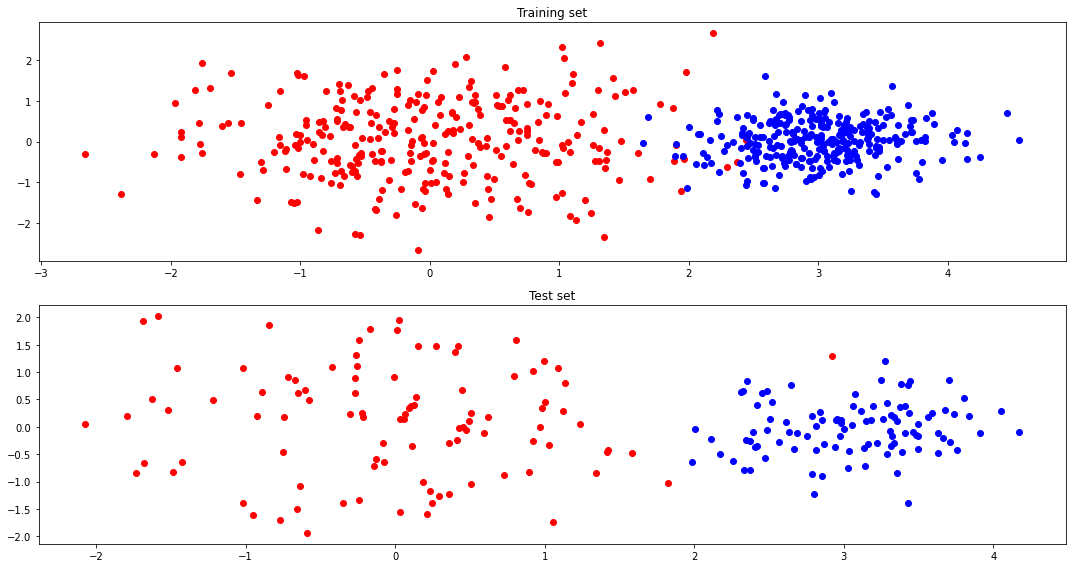

In [63]:
# Help for data-generation
means = [[3, 0], [0, 0]]
sigmas = [0.5, 1]

Xtr, Ytr = mixGauss(means, sigmas, 300)
Xts, Yts = mixGauss(means, sigmas, 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

# TODO: Plot training and test sets, coloring the two classes differently.

fig, _ = plt.subplots()
plt.subplot(2,1,1)
plt.scatter(Xtr_wbias[Ytr == 1,0], Xtr_wbias[Ytr == 1, 1], color = 'r')
plt.scatter(Xtr_wbias[Ytr == -1,0], Xtr_wbias[Ytr == -1, 1], color = 'b')

plt.title("Training set")
plt.subplot(2,1,2)
plt.scatter(Xts_wbias[Yts == 1,0], Xts_wbias[Yts == 1, 1], color = 'r')
plt.scatter(Xts_wbias[Yts == -1,0], Xts_wbias[Yts == -1, 1], color = 'b')
plt.title("Test set")
fig.tight_layout()

Text(0.5, 1.0, 'Loss for iteration')

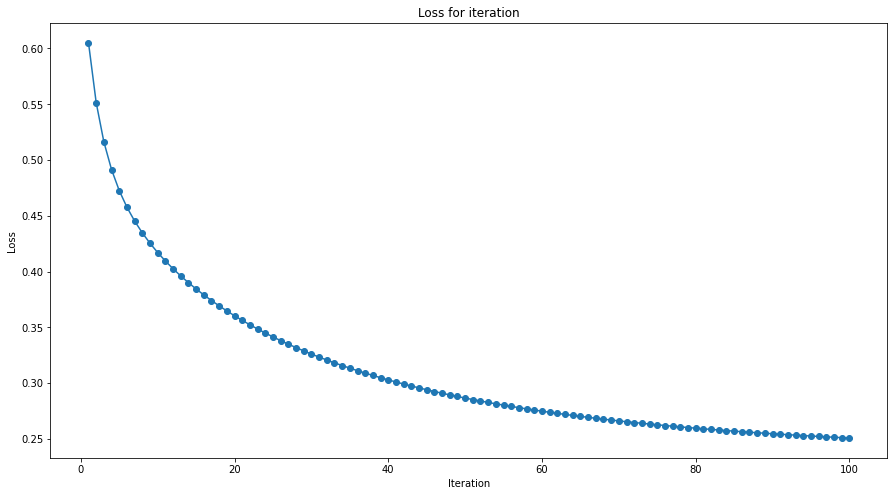

In [64]:
reg_par = 0.01
estw, losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par)  # Careful: use the datasets with the bias.

# TODO: Plot the losses

plt.plot(range(1, len(losses)+1), losses, '-o')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss for iteration")

As we expected, as the iteration number increases, the corresponding loss decreases

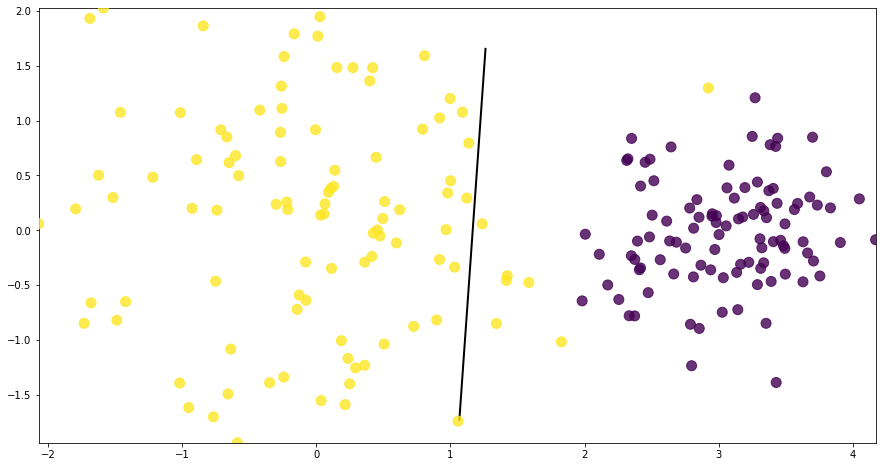

In [65]:
# TODO: Plot the separating curve (on the test set)
ts_pred, _ = predict_logreg(estw, Xts_wbias)
separatingFLR(Xts, Yts, ts_pred, estw)

In [66]:
# TODO: Evaluate the errors
tr_pred, _ = predict_logreg(estw, Xtr_wbias)
tr_err = calcError(tr_pred, Ytr)
ts_pred, _ = predict_logreg(estw, Xts_wbias)
ts_err = calcError(ts_pred, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (tr_err * 100, ts_err * 100))

Training error: 6.17%, Test error: 3.50%


## Interpreting the confidence of logistic regression predictions

Logistic regression does not only output *pointwise predictions* (the class to which a point belongs), but it also gives the **probability** that a test point belongs to a certain class.

This probability can be very useful to interpret the outputs of your model: in certain cases it might be better to **not predict anything** if the confidence of the model is low (i.e. if the model predicts a probability of 0.5 in a binary setting, the model is not sure which class a point belongs to).

In this part of the lab, we will
 1. Implement a function which allows to visualize the confidence of predictions (`plot_logreg_confidence`)
 2. Train a logistic regression model, and use the visualization function to see where the low confidence region of prediction lies.
 3. Calculate the error on **just the high-confidence** predictions, and see how the it changes.

In [67]:
def plot_logreg_confidence(X, Y, pred_confidence, threshold):
    """
    X : a (n, d) dataset
    Y : a (n, ) array of targets
    pred_confidence : A (n, ) array of probabilities predicted from X
    threshold : a float between 0 and 0.5 determining the probability threshold we use to 
                consider neutral predictions. For example if threshold=0.1 then all probabilities
                between 0.4 and 0.6 will be considered neutral (that is, neither belonging to class +1
                or to class -1).
    """
    fig, ax = plt.subplots()
    xi = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
    yi = np.linspace(X[:, 1].min(), X[:, 1].max(), 200)
    X_grid, Y_grid = np.meshgrid(xi,yi)
    
    zi = griddata(X, pred_confidence, (X_grid, Y_grid), method='linear')
    
    ax.contour(xi, yi, zi, 15, linewidths=2, levels=[0.5 - threshold, 0.5 + threshold])
    
    # Plot data points
    ax.scatter(X[:,0], X[:,1], c=Y, 
               marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(X[:,0].min(), X[:,0].max())
    ax.set_ylim(X[:,1].min(), X[:,1].max())

In [68]:
# Generate some data
Xtr, Ytr = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)
Xts, Yts = mixGauss([[0,1],[1,1]], [0.4,0.4], 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

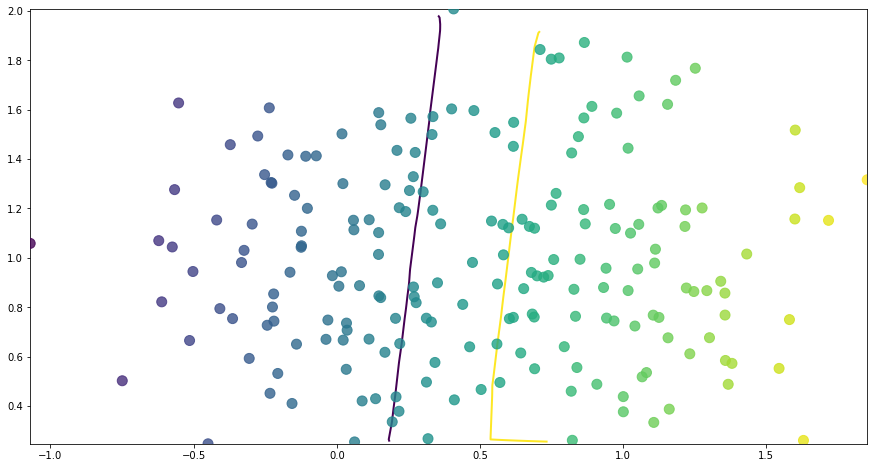

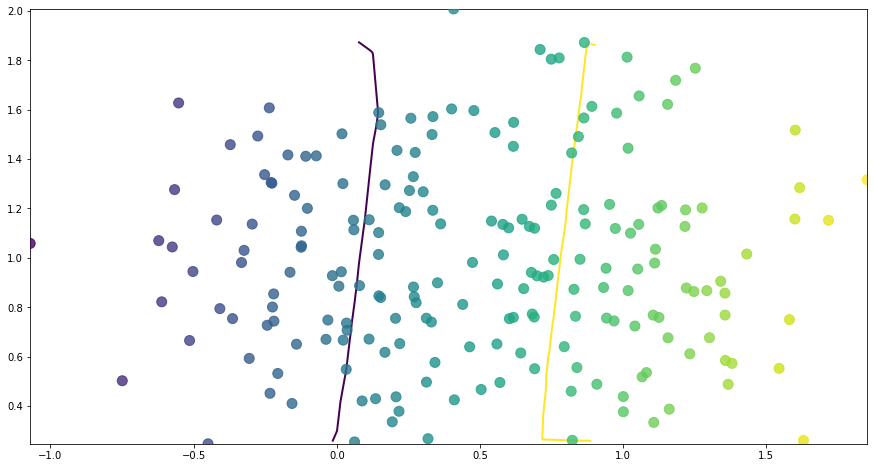

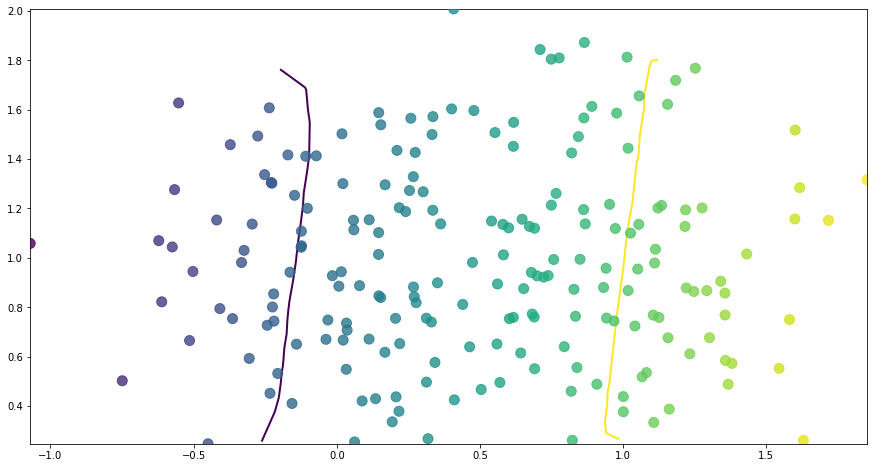

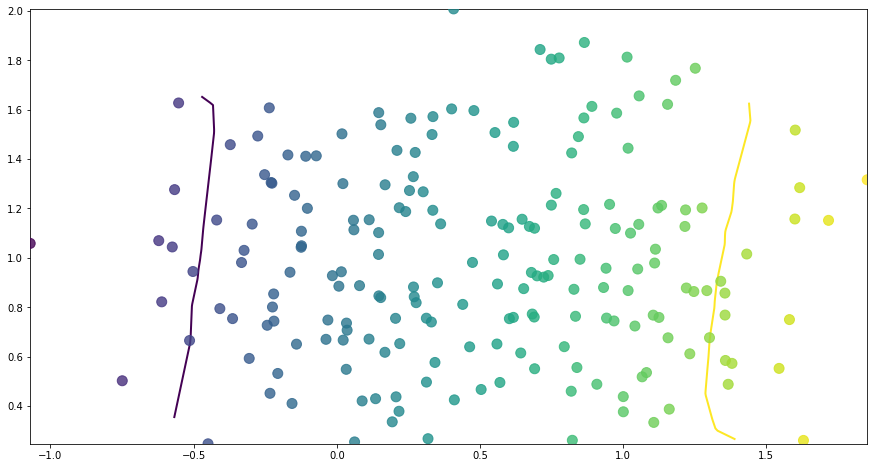

In [69]:
# TODO: Train a logistic regression model, and obtain the probability predictions for the test set
estw, losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par) 
ts_pred, ts_conf = predict_logreg(estw, Xts_wbias)
# TODO: Plot the logistic regression confidence for different thresholds. Interpret what you see.
thresholds = np.arange(0.1, 0.5, 0.1)

for threshold in thresholds:
    plot_logreg_confidence(Xts, ts_pred, ts_conf, threshold)

We can see that the higher the threshold is and the lesser are the points that are considered to have been classified correctly; this can be noticed by the two lines in the plots, the higher the threshold is and the more far apart this lines are; consequently, the lesser are the points to the left of the purple line and to the right of the yellow line, that is, the points considered to be classified correctly.

In [70]:
def calc_error_with_confidence(prob_pred, Y, threshold):
    """
    Calculate the classification error on only the predictions with a high confidence!
    """
    class_m1 = prob_pred <= 0.5 - threshold
    class_p1 = prob_pred > 0.5 + threshold
    
    err_class_m1 = Y[class_m1] != -1
    err_class_p1 = Y[class_p1] != 1
    return (np.sum(err_class_m1) + np.sum(err_class_p1)) / (len(err_class_m1) + len(err_class_p1))

Text(0.5, 1.0, 'Confidence-related error')

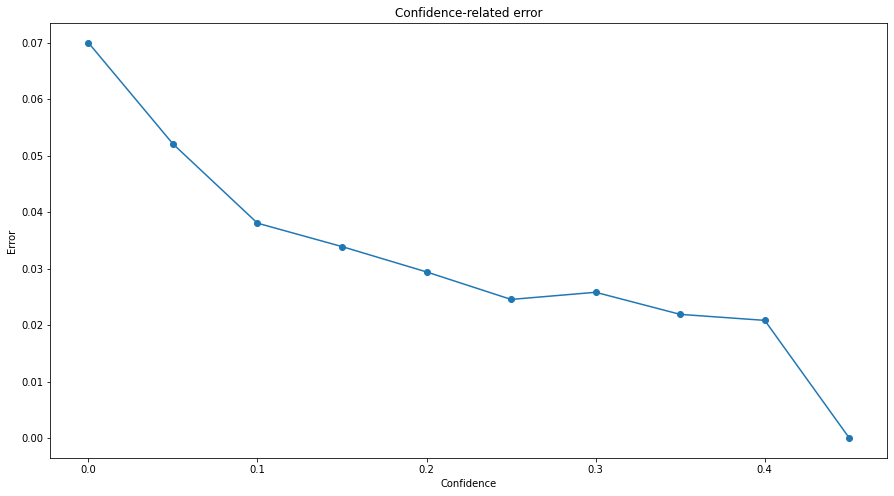

In [71]:
# TODO: Train a log-reg model, and calculate the error on only the high-confidence examples from the test
#       set. How do you expect this error to behave as you change the threshold?

means = [[3, 0], [0, 0]]
sigmas = [0.5, 1]

Xtr, Ytr = mixGauss(means, sigmas, 100)
Xts, Yts = mixGauss(means, sigmas, 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

estw, losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par) 
ts_pred, ts_conf = predict_logreg(estw, Xts_wbias)

thresholds = np.arange(0, 0.5, 0.05)
error_high_confidence = []

for threshold in thresholds:
    error_high_confidence.append(calc_error_with_confidence(ts_conf, Yts, threshold))

plt.plot(thresholds, error_high_confidence, '-o')
plt.xlabel("Confidence")
plt.ylabel("Error")
plt.title("Confidence-related error")

As we might have expected, the error is lower the higher the threshold. That's because the higher the threshold, the more confident the model is in the predictions we are considering (predictions with high confidence)

## Logistic Regression with Stochastic Gradient Descent

SGD is quite similar to GD, but instead of updating the weights with the gradient of all the training samples at once, at each step it updates the weights with the **gradient of a single sample** picked at random from the training set.

Since at each iteration it uses a single sample it will be much faster, but it will need more iterations.

In this last part you will:
 1. Implement a SGD solver for logistic regression
 2. Use it to learn a logistic-regression model
 3. Compare the results to learning with GD.

In [72]:
def gradient_one_sample(x_i, y_i, reg_par, w):
    g = 0

    denominator = 1+np.exp(y_i*np.dot(x_i, w))
    fraction = -y_i/denominator
    g += np.atleast_2d(x_i * fraction).T
    g += 2 * reg_par * w

    return g

In [73]:
def loss_function_one_sample(x_i, y_i, reg_par, w):
    loss = 0

    exp = np.exp(-y_i*np.dot(x_i, w))
    loss += np.log(1 + exp)
    loss += reg_par * np.linalg.norm(w)**2

    return loss

In [74]:
def train_logreg_sgd(Xtr, Ytr, reg_par, maxiter=100):
    """
    Xtr : array of shape n, d
    Ytr : array of shape n, or of shape n, 1
    reg_par : regularization parameter (a scalar)
    maxiter : the maximum number of gradient-descent iterations
    """
    epsilon = 1e-6
    # size of the input in the training
    n, D = np.shape(Xtr)
    # initialization of the vector w
    w = np.zeros((D, 1))
    
    # initialization of some supporting variables
    training_losses = np.zeros(maxiter)
    Ytr = Ytr.reshape(-1, 1)  # Convert from shape n, to shape n, 1
    j = 0
    for j in range(maxiter):
        # The learning rate here is different from GD. You can take
        # a) 1 / sqrt(n)
        # b) 1 / sqrt(j) : the learning rate decreases at each iteration.
        # Which one do you expect leads to faster convergence?
        gamma = 1 / np.sqrt(n) ### b leads to faster convergence than a because we initially take big steps towords our goal and the more we proceed the smaller these steps become
        
        # TODO: Choose the sample current stample from Xtr **at random**
        sample_idx = randint(0, n-1)
        
        # TODO: Use the formulas from the slides to update the weight vector
        w = w - gamma * gradient_one_sample(Xtr[sample_idx], Ytr[sample_idx], reg_par, w)
        # TODO: Calculate the loss on the current sample.
        loss = loss_function_one_sample(Xtr[sample_idx], Ytr[sample_idx], reg_par, w)
        training_losses[j] = loss
        
        if j > 0 and abs(training_losses[j] - training_losses[j-1]) < epsilon:
            break
        
    return w, training_losses[:j]

In [107]:
# TODO: Generate a dataset (use the code from the previous parts)
means = [[3, 0], [0, 0]]
sigmas = [0.5, 1]

Xtr, Ytr = mixGauss(means, sigmas, 300)
Xts, Yts = mixGauss(means, sigmas, 100)

Xtr_wbias = np.hstack((Xtr, np.ones((Xtr.shape[0], 1))))
Xts_wbias = np.hstack((Xts, np.ones((Xts.shape[0], 1))))

In [108]:
# TODO: Train logistic regression with SGD
SGD_estw, SGD_losses = train_logreg_sgd(Xtr_wbias, Ytr, reg_par, 100)
# TODO: Train logistic regression with GD
GD_estw, GD_losses = train_logreg_gd(Xtr_wbias, Ytr, reg_par, 100)

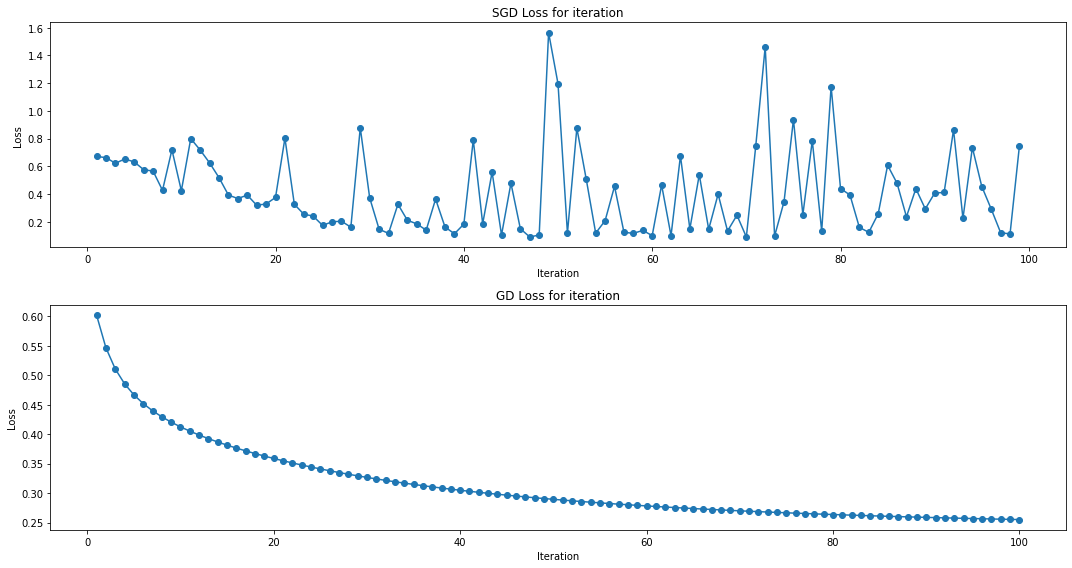

In [109]:
# TODO: Compare the two in terms of:
#  1. number of iterations needed to converge (keep in mind that GD iterations cost n times more)
#  2. accuracy.

fig, _ = plt.subplots()
plt.subplot(2,1,1)
plt.plot(range(1, len(SGD_losses)+1), SGD_losses, '-o')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("SGD Loss for iteration")

plt.subplot(2,1,2)
plt.plot(range(1, len(GD_losses)+1), GD_losses, '-o')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("GD Loss for iteration")
fig.tight_layout()

From the two plots above we can see that SGD converges before GD. Hence in terms of iterations, SGD is faster than GD, also considering the fact that GD costs n times more than SGD at each iteration.

But, if we had computed the loss over the whole dataset, we would have seen that GD converges faster than SGD because it takes more iterations for SGD to converge than GD.

In [110]:
SGD_tr_pred, _ = predict_logreg(SGD_estw, Xtr_wbias)
SGD_tr_err = calcError(SGD_tr_pred, Ytr)
SGD_ts_pred, _ = predict_logreg(SGD_estw, Xts_wbias)
SGD_ts_err = calcError(SGD_ts_pred, Yts)

GD_tr_pred, _ = predict_logreg(GD_estw, Xtr_wbias)
GD_tr_err = calcError(GD_tr_pred, Ytr)
GD_ts_pred, _ = predict_logreg(GD_estw, Xts_wbias)
GD_ts_err = calcError(GD_ts_pred, Yts)

print(f"SGD Training error: {SGD_tr_err * 100}, SGD Test error: {SGD_ts_err * 100}")
print(f"GD Training error: {GD_tr_err * 100}, GD Test error: {GD_ts_err * 100}")

SGD Training error: 11.333333333333332, SGD Test error: 10.5
GD Training error: 6.833333333333333, GD Test error: 6.0


We can notice though that the error of SGD is actually higher than the error of GD. This is due the fact that SGD relies more on the single points and hence it is more prone to overfitting, while GD is more stable, consistent and generalizes better as it is based on a comprehensive evaluation of the entire dataset. If we had considered more iterations though, the errors would have been closer to each other. (with SGD higher anyway)